In [1]:
%cd ../src
%load_ext autoreload
%autoreload 2

/home/ubuntu/SPVD_Lightning/src


In [2]:
from models.ddpm_unet_cattn import SPVUnet
import torch
import lightning as L
from models.g_spvd import GSPVD

In [ ]:
## Hyperparameters
scheduler = 'ddim'
conditional = True

categories = ['airplane']
steps_to_run = [1000, 500, 250, 125, 63, 32, 16, 8, 4, 2]

In [22]:
from torch.utils.data import DataLoader
from dataloaders.shapenet.shapenet_loader import ShapeNet

path = "../data/ShapeNet"

test_dataset = ShapeNet(path, "test", 2048, categories, load_renders=True, total=50)

Loading (test) renders for airplane (02691156):   0%|          | 0/808 [00:00<?, ?it/s]

In [77]:
ref = test_dataset[23, 4]
ref_img = ref["render-features"].unsqueeze(0).cuda() if conditional else None
real_pc = ref["pc"].numpy()

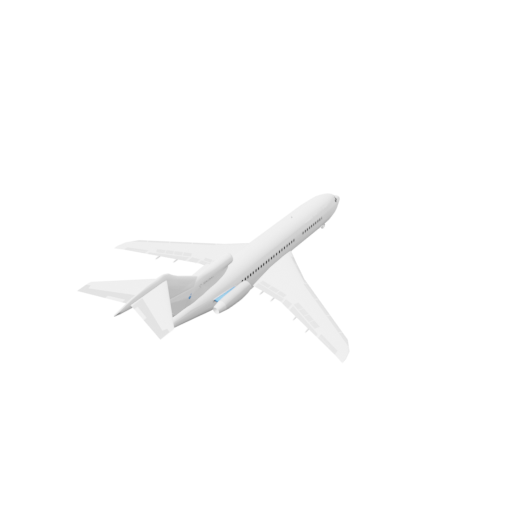

In [78]:
from PIL import Image
img = Image.open("../data/ShapeNet/renders/" + ref['filename'] + f"/00{ref['selected-view']}.png")
img

In [79]:
from utils.hyperparams import load_hyperparams

hparams_path = f'../checkpoints/distillation/GSPVD/{"-".join(categories)}/hparams.yaml'

hparams = load_hyperparams(hparams_path)

In [80]:
model_args = {
    'voxel_size' : hparams['voxel_size'],
    'nfs' : hparams['nfs'], 
    'attn_chans' : hparams['attn_chans'], 
    'attn_start' : hparams['attn_start'], 
    'cross_attn_chans' : hparams['cross_attn_chans'], 
    'cross_attn_start' : hparams['cross_attn_start'], 
    'cross_attn_cond_dim' : hparams['cross_attn_cond_dim'],
}

model = SPVUnet(**model_args)
model = GSPVD(model=model)

In [81]:
model = model.cuda().eval()

In [92]:
from my_schedulers.ddpm_scheduler import DDPMSparseScheduler
from my_schedulers.ddim_scheduler import DDIMSparseScheduler
from utils.helper_functions import process_ckpt

def get_sched(steps):
    if scheduler == 'ddim':
        sched = DDIMSparseScheduler(
            beta_min=hparams['beta_min'], 
            beta_max=hparams['beta_max'], 
            steps=steps, 
            init_steps=hparams['n_steps'],
            mode=hparams['mode'],
        )
    elif distilled:
        sched = DDPMSparseScheduler(
            beta_min=hparams['beta_min'], 
            beta_max=hparams['beta_max'], 
            steps=steps, 
            init_steps=hparams['n_steps'],
            mode=hparams['mode'],
        )
    else:
        sched = DDPMSparseScheduler(
            beta_min=hparams['beta_min'], 
            beta_max=hparams['beta_max'], 
            steps=steps, 
            init_steps=steps,
            mode=hparams['mode'],
        )
    return sched

def get_ckpt(steps, conditiona, step_size=1):
    if distilled:
        ckpt_path = f'../checkpoints/distillation/GSPVD/{"-".join(categories)}/new/{steps}-steps.ckpt'
    elif scheduler == 'ddim':
        ckpt_path = f'../checkpoints/distillation/GSPVD/{"-".join(categories)}/1000-steps.ckpt'
    else:
        ckpt_path = f'../checkpoints/ShapeNet/GSPVD/{"-".join(categories)}/{scheduler}/{steps}-steps.ckpt'

    ckpt = torch.load(ckpt_path, weights_only=False)
    ckpt = process_ckpt(ckpt)
    return ckpt
    

In [98]:
import time

display = [real_pc]
# start_noise = None
distilled = False

ckpt = get_ckpt(steps, conditional)
model.load_state_dict(ckpt)

for steps in steps_to_run:
    # ckpt = get_ckpt(steps, conditional)
    # model.load_state_dict(ckpt)
    sched = get_sched(steps)
    
    if start_noise is None:
        start_noise = sched.create_noise((1, 2048, 3), device='cuda')

    start_time = time.time()
    gen_pc = sched.sample(model, 1, 2048, 3, reference=ref_img, starting_noise=start_noise, guidance_scale=1)
    print(f"Generated point cloud in {time.time() - start_time:.2f} seconds for {steps} steps")
    display.append(gen_pc[0].cpu().detach().numpy())

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Generated point cloud in 28.44 seconds for 1000 steps


Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Generated point cloud in 14.01 seconds for 500 steps


Sampling:   0%|          | 0/250 [00:00<?, ?it/s]

Generated point cloud in 7.03 seconds for 250 steps


Sampling:   0%|          | 0/125 [00:00<?, ?it/s]

Generated point cloud in 3.53 seconds for 125 steps


Sampling:   0%|          | 0/63 [00:00<?, ?it/s]

Generated point cloud in 1.80 seconds for 63 steps


Sampling:   0%|          | 0/32 [00:00<?, ?it/s]

Generated point cloud in 0.92 seconds for 32 steps


Sampling:   0%|          | 0/16 [00:00<?, ?it/s]

Generated point cloud in 0.47 seconds for 16 steps


Sampling:   0%|          | 0/8 [00:00<?, ?it/s]

Generated point cloud in 0.23 seconds for 8 steps


Sampling:   0%|          | 0/4 [00:00<?, ?it/s]

Generated point cloud in 0.12 seconds for 4 steps


Sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Generated point cloud in 0.07 seconds for 2 steps


In [94]:
from utils.visualization import display_pointclouds_grid
display_pointclouds_grid(display, offset=10, point_size=0.3, grid_dims=(3, 4))

Output()

In [95]:
from utils.helper_functions import send_to_local
send_to_local(display, ref['filename'], ref['selected-view'], f"ddim-{steps_to_run}", categories[0])
# send_to_local(display, ref['filename'], ref['selected-view'], f"distillation-{steps_to_run}", categories[0])